# Week 5

Patrick Weatherford

***


<br>

## Import Modules

Mount Google Drive to Colab session

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


<br>Install necessary modules not pre-installed by Colab

In [ ]:
%%capture
!pip install python-Levenshtein
!pip install fuzzywuzzy


<br>Copy custom packages/moduls over to default path where python packages are installed for this Colab session.

In [ ]:
import os
import site
import shutil

# create custom modules folder in default pkg location
dest_path = site.getsitepackages()[0]  # get path where packages are installed
colab_cust_mod_path = f"{dest_path}/hakuna_patata_modules"

if not os.path.exists(colab_cust_mod_path):
    os.makedirs(colab_cust_mod_path)

# create init file in custom modules folder
with open(f"{colab_cust_mod_path}/__init__.py", 'w') as f:
    pass

mods = ['api_keys.py', 'hakuna_patata.py']  # modules to copy over

mod_path = r'/content/drive/MyDrive/Bellevue_University/Python/Custom_Modules'

for mod in mods:
    file_path = f"{mod_path}/{mod}"
    shutil.copy2(file_path, colab_cust_mod_path)


In [ ]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from zipfile import ZipFile
from scipy.sparse import vstack

from nltk.corpus import stopwords
from nltk import download as nltk_download
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

import hakuna_patata_modules.api_keys as api_keys
import hakuna_patata_modules.hakuna_patata as hakuna_patata
from google.colab import data_table
data_table.enable_dataframe_formatter()

nltk_download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

***

<br>

## Import Kaggle Dataset

In [ ]:
kaggle_download_path = r'/content/kaggle_datasets'
kaggle_username = api_keys.Kaggle_API['username']
kaggle_api_key = api_keys.Kaggle_API['key']
kaggle_comp = 'word2vec-nlp-tutorial'
data_files = ['labeledTrainData.tsv.zip', 'testData.tsv.zip', 'unlabeledTrainData.tsv.zip']

# Create Kaggle api object
kaggle_api = hakuna_patata.kaggle_api(kaggle_username, kaggle_api_key)

# Create directory for files to download to
if not os.path.exists(kaggle_download_path):
    os.makedirs(kaggle_download_path)

# Download data files from Kaggle
for data_file in data_files:
    kaggle_api.competition_download_file(competition=kaggle_comp, file_name=data_file, path=kaggle_download_path, force=True, quiet=True)

df_list = []

for i, data_file in enumerate(data_files):
    with ZipFile(f"{kaggle_download_path}/{data_file}") as zip_file:
        data = zip_file.open(data_file.replace('.zip', ''))
        df = pd.read_csv(data, header=0, sep='\t', quoting=3)
        df_list.append(df)

initial_df = df_list[0]

del df_list


In [ ]:
initial_df.drop('id', axis=1, inplace=True)

initial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  25000 non-null  int64 
 1   review     25000 non-null  object
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


<br>

## Prep Data

In [ ]:
%%time
clean_df = initial_df
stop_words = stopwords.words('english')  # get stop words to remove from review
clean_df['review'] = (
    clean_df['review'].str.lower()  # make lowercase
    .str.replace(r'[^A-Za-z0-9\s]', '', regex=True)  # only include non-alphanumeric and white space
    .apply(lambda x: " ".join([word for word in x.split() if word not in stop_words]))  # remove stop words
    .apply(lambda x: PorterStemmer().stem(x))  # get stem of word
)


CPU times: user 21.3 s, sys: 89 ms, total: 21.4 s
Wall time: 27.6 s


In [ ]:
clean_df

,sentiment,review
0,1,stuff going moment mj ive started listening mu...
1,1,classic war worlds timothy hines entertaining ...
2,0,film starts manager nicholas bell giving welco...
3,0,must assumed praised film greatest filmed oper...
4,1,superbly trashy wondrously unpretentious 80s e...
...,...,...
24995,0,seems like consideration gone imdb reviews fil...
24996,0,dont believe made film completely unnecessary ...
24997,0,guy loser cant get girls needs build picked st...
24998,0,30 minute documentary buuel made early 1930s o...


<br>

## Make Train/Test Sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    clean_df['review'],
    clean_df['sentiment'],
    test_size=0.3,
    random_state=777
)

# check to see if imbalance in target exists
train_pos_proportion = ( y_train[y_train==1].size / y_train.size )
print(f"""
Training Set Positive Sentiment: {train_pos_proportion:.2%} 
"""
)



Training Set Positive Sentiment: 49.98% 



<br>

## TF-IDF Vectorization

Will fit and apply TF-IDF vectorization to the training set which will weight the importance of words based on the frequency within a single observation in the training set (aka single document) and will compare that with the frequency of words within the corpus of the training set (aka all documents).

The word weights created from the training set will then be applied to the test set. The training set corpus is not considered when fitting word importance because it will cause data leakage which has the potential to produce a model that does not generalize very well.

In [ ]:
%%time
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)  # from tfidf object, fit on train set
X_test_tfidf = tfidf.transform(X_test)  # transform test data based on pre-fit tfidf obj


CPU times: user 2.35 s, sys: 26.8 ms, total: 2.38 s
Wall time: 2.39 s


<br>

## Logistic Regression

### Train Logit Model

In [ ]:
%%time
logit = LogisticRegression(random_state=777)  # create logit obj

logit.fit(X=X_train_tfidf, y=y_train)  # train the logit obj using train data

logit_score = logit.score(X_test_tfidf, y_test)  # get accuracy of model on test data

print(f"Logit accuracy: {logit_score:.2%}")

Logit accuracy: 88.79%
CPU times: user 963 ms, sys: 878 ms, total: 1.84 s
Wall time: 999 ms


<br>

### Confusion Matrix

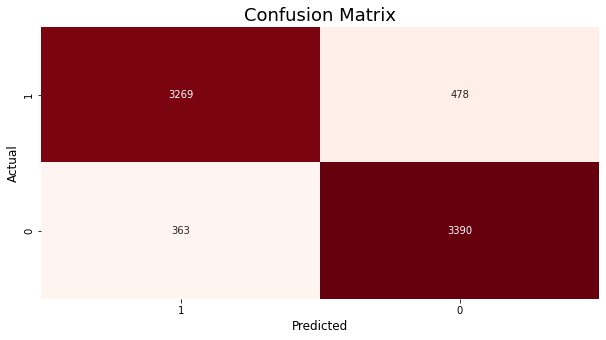

In [ ]:
y_pred = logit.predict(X_test_tfidf)  # get predicted values

cm = confusion_matrix(
    y_true=y_test,
    y_pred=y_pred
)

cm_classes = [str(class_name) for class_name in y_test.unique()]

cm_df = pd.DataFrame(cm, index=cm_classes, columns=cm_classes)

plt.figure(figsize=(10,5))
sns.heatmap(cm_df, annot=True, cbar=None, cmap='Reds', fmt='g')
plt.title('Confusion Matrix', fontdict={'fontsize':18})
plt.ylabel('Actual', fontdict={'fontsize':12})
plt.xlabel('Predicted', fontdict={'fontsize':12})
plt.show()

<br>

### Precision, Recall, f1, Accuracy

In [ ]:
print(classification_report(
    y_test,
    y_pred,
    target_names=cm_classes
))

              precision    recall  f1-score   support

           1       0.90      0.87      0.89      3747
           0       0.88      0.90      0.89      3753

    accuracy                           0.89      7500
   macro avg       0.89      0.89      0.89      7500
weighted avg       0.89      0.89      0.89      7500



*No alarming inconsistencies between accuracy, precision, recall, and f1-score*

<br>

### Cross Validation

In [ ]:
%%time
X_tfidf = vstack([X_train_tfidf, X_test_tfidf])
y = pd.concat([y_train, y_test])

kf = KFold(n_splits=10, shuffle=True, random_state=777)

cv_results = cross_val_score(
    estimator=logit,
    X=X_tfidf,
    y=y,
    cv=kf,
    scoring='accuracy',
    n_jobs=-1
)

print(cv_results)

[0.8828 0.8848 0.8828 0.8884 0.88   0.894  0.8916 0.8812 0.8972 0.8992]
CPU times: user 195 ms, sys: 75.6 ms, total: 270 ms
Wall time: 13.4 s


*No anomolies found in cross validation. Accuracy is consistent*

<br>

### ROC Curve

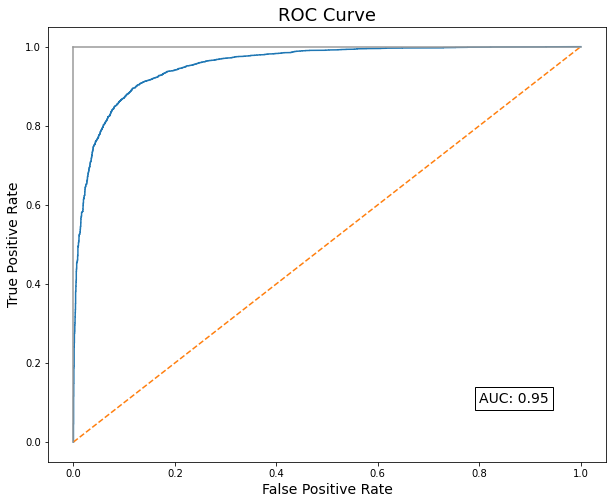

In [ ]:
y_pred_proba = logit.predict_proba(X_test_tfidf)[:,1]

false_pos_rate, true_pos_rate, threshold = roc_curve(
    y_test,
    y_pred_proba
)

roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(10,8))
plt.plot(false_pos_rate, true_pos_rate)  # roc curve
plt.plot([0, 1], ls="--")  # diagonal dashed line
plt.plot([0, 0], [1, 0], c=".6")  # vertical grey line
plt.plot([1, 1], c=".6")  # horizontal grey line
plt.title("ROC Curve", fontdict={'fontsize':18})
plt.xlabel("False Positive Rate", fontdict={'fontsize':14})
plt.ylabel("True Positive Rate", fontdict={'fontsize':14})
plt.text(.8, .1, f"AUC: {round(roc_auc,2)}", fontsize=14, bbox=dict(facecolor='white'))
plt.show()

<br>

## Random Forest Classifier

In [ ]:
%%time
rf = RandomForestClassifier(random_state=777)

rf_model = rf.fit(X_train_tfidf, y_train)  # train model using train data

rf_y_pred = rf_model.predict(X_test_tfidf)  # get test set predicted values

rf_score = rf_model.score(X_test_tfidf, y_test)  # get model accuracy

print(f"Random Forest Classifier Accuracy: {rf_score:.2%}")

Random Forest Classifier Accuracy: 84.84%
CPU times: user 36 s, sys: 79.9 ms, total: 36 s
Wall time: 35.8 s


*From results, Random Forest is less accurate and takes longer to train when the features are TF-IDF vectorized.*

<br>

### Confusion Matrix

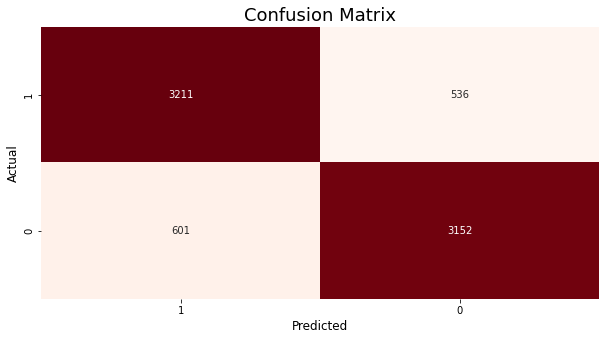

In [ ]:
cm = confusion_matrix(
    y_true=y_test,
    y_pred=rf_y_pred
)

cm_classes = [str(class_name) for class_name in y_test.unique()]

cm_df = pd.DataFrame(cm, index=cm_classes, columns=cm_classes)

plt.figure(figsize=(10,5))
sns.heatmap(cm_df, annot=True, cbar=None, cmap='Reds', fmt='g')
plt.title('Confusion Matrix', fontdict={'fontsize':18})
plt.ylabel('Actual', fontdict={'fontsize':12})
plt.xlabel('Predicted', fontdict={'fontsize':12})
plt.show()

<br>

### Precision, Recall, f1, Accuracy

In [ ]:
print(classification_report(
    y_test,
    rf_y_pred,
    target_names=cm_classes
))

              precision    recall  f1-score   support

           1       0.84      0.86      0.85      3747
           0       0.85      0.84      0.85      3753

    accuracy                           0.85      7500
   macro avg       0.85      0.85      0.85      7500
weighted avg       0.85      0.85      0.85      7500



*No alarming inconsistencies between accuracy, precision, recall, and f1-score*

<br>

### Cross Validation

In [ ]:
%%time
X_tfidf = vstack([X_train_tfidf, X_test_tfidf])
y = pd.concat([y_train, y_test])

kf = KFold(n_splits=3, shuffle=True, random_state=777)

cv_results = cross_val_score(
    estimator=rf,
    X=X_tfidf,
    y=y,
    cv=kf,
    scoring='accuracy',
    n_jobs=-1
)

print(cv_results)

[0.84257259 0.84267371 0.84075363]
CPU times: user 828 ms, sys: 152 ms, total: 981 ms
Wall time: 2min 1s


*Cross validation took over 20min with Random Forest using n_splits=10. Dropped to n_splits=3. After execution, there are no inconsistencies in the accuracy scores.*

<br>

### ROC Curve

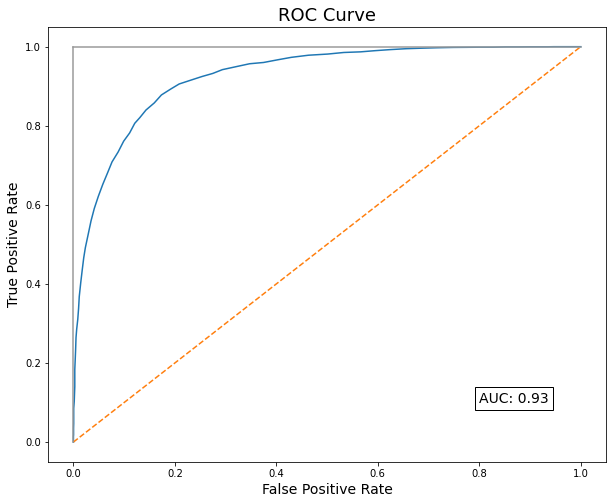

In [ ]:
y_rf_pred_proba = rf.predict_proba(X_test_tfidf)[:,1]

false_pos_rate, true_pos_rate, threshold = roc_curve(
    y_test,
    y_rf_pred_proba
)

roc_auc = roc_auc_score(y_test, y_rf_pred_proba)

plt.figure(figsize=(10,8))
plt.plot(false_pos_rate, true_pos_rate)  # roc curve
plt.plot([0, 1], ls="--")  # diagonal dashed line
plt.plot([0, 0], [1, 0], c=".6")  # vertical grey line
plt.plot([1, 1], c=".6")  # horizontal grey line
plt.title("ROC Curve", fontdict={'fontsize':18})
plt.xlabel("False Positive Rate", fontdict={'fontsize':14})
plt.ylabel("True Positive Rate", fontdict={'fontsize':14})
plt.text(.8, .1, f"AUC: {round(roc_auc,2)}", fontsize=14, bbox=dict(facecolor='white'))
plt.show()